In [1]:
# Load libs:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from glob import glob
from os.path import dirname, abspath, join, exists
from clearml import Task
from amplify.data import DataGenerator, DataSplit

In [2]:
# ClearML Stuff
task = Task.init(project_name="amplify", task_name="predict_power_gen_initial_model")

ClearML Task: overwriting (reusing) task id=fd8dec0a0d1d48268fad4644d9a15f90
ClearML results page: https://app.clear.ml/projects/f0e0b096252d4c18b9005e580afc5bce/experiments/fd8dec0a0d1d48268fad4644d9a15f90/output/log


## Load Data

In [3]:
xy_data = DataGenerator().load_data()
xy_data.head()

ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Info: Successfully loaded Building data!
Info: Successfully loaded Weather data!
Successfully merged Building and Weather data!
Successfully added Azimuth and Irradiance data!


,temp,clouds_all,azimuth,irradiance,day_of_week,True Power (kW) solar,True Power (kW) usage
2021-10-19 04:00:00+00:00,11.18,75.0,338.24,0.0,2,1.0,11.3
2021-10-19 05:00:00+00:00,9.51,20.0,7.14,0.0,2,1.0,13.2
2021-10-19 06:00:00+00:00,9.28,20.0,34.06,0.0,2,1.0,12.7
2021-10-19 07:00:00+00:00,9.28,20.0,54.27,0.0,2,1.0,17.2
2021-10-19 08:00:00+00:00,9.28,20.0,69.01,0.0,2,1.0,17.0


## Data Processing

```
1. Make xy data into a set of series of shape [N, M, F], where N = number of examples; M = nubmer of timestamps; F = Number of features.
2. Train-Test-Validation Split. Split off at 0.8, 0.1, 0.1 ratio for now. Shuffle the split.
3. Seperate x, y from dataset. Remove last column from dataset to extract y.
```

In [4]:
# Hyperparameters 
SERIES = 48
STRIDE = 1

In [5]:
# This in each set includes both solar and power gen
# e.g. train_ds[0] = x_train,
#      train_ds[1] = y_train
train_ds, val_ds, test_ds = DataSplit(xy_data, series_length=SERIES, stride=STRIDE).split_data()

In [6]:
# Isolate XY from datasets
x_train, y_train,  = (
    train_ds[0],
    train_ds[1],
)  # Training data
x_val, y_val = (
    val_ds[0],
    val_ds[1],
)  # Validation data
x_test, y_test = (
    test_ds[0],
    test_ds[1],
)  # Test data

In [7]:
print("x_train shape: ", x_train.shape)

x_train shape:  (1556, 48, 5)


In [8]:
print("y_train shape: ", y_train.shape)

y_train shape:  (1556, 48, 2)


In [9]:
def split_solar_power_y(y_data):
    y_solar = y_data[:, :, -2:-1].astype("float32")
    y_power = y_data[:, :, -1:].astype("float32")
    return y_solar, y_power

In [10]:
# seperate solar gen, power usage for training models using just one data type
y_solar_train, y_power_train    = split_solar_power_y(y_train)
y_solar_val, y_power_val        = split_solar_power_y(y_val)
y_solar_test, y_power_test      = split_solar_power_y(y_test)

In [11]:
# verify that this worked
print("y_power_train shape: ", y_power_train.shape)
print("y_solar_train shape: ", y_solar_train.shape)

y_power_train shape:  (1556, 48, 1)
y_solar_train shape:  (1556, 48, 1)


### Train Normalizer on XTrain

In [12]:
from keras.layers import Normalization

In [13]:
# Normalize to x_train data
norm_layer = Normalization()
norm_layer.adapt(x_train)

2022-01-30 22:26:09.368217: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Test Models

In [14]:
# below import also includes tf/keras stuff
from amplify.models import *
from amplify.metrics import *

In [15]:
# model evaluation
model_eval = DataEval()

## 1. Simple LSTM On Solar Gen

In [16]:
# hyperparameters
NUM_LSTM_LAYER=20
SERIES_FT = 5
SERIES_OUT = 1
BATCH  = 4
EPOCHS = 30
activation_fn = 'tanh'

In [17]:
# create model
lstm_model_1 = SimpleLSTM_1(
    norm_layer=norm_layer,
    n_layer=NUM_LSTM_LAYER,
    n_series_len=SERIES,
    n_series_ft=SERIES_FT,
    n_series_out=SERIES_OUT,
    activation_f=activation_fn
)

# set hyper param
lstm_model_1.SetHyperParam(
    epoch=EPOCHS,
    batch_size=BATCH
)
lstm_model_1.DisplayModel()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 48, 5)            11        
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 48, 20)            2080      
                                                                 
 time_distributed (TimeDistr  (None, 48, 1)            21        
 ibuted)                                                         
                                                                 
Total params: 2,112
Trainable params: 2,101
Non-trainable params: 11
_________________________________________________________________


In [18]:
# train model
lstm_model_1.TrainModel(x_train=x_train, y_train=y_solar_train, x_val=x_val, y_val=y_solar_val)

Epoch 1/30
389/389 [==============================] - 10s 20ms/step - loss: 4.8977 - root_mean_squared_error: 9.6928 - val_loss: 4.1777 - val_root_mean_squared_error: 8.3408 - lr: 0.0010
Epoch 2/30
389/389 [==============================] - 6s 15ms/step - loss: 3.5160 - root_mean_squared_error: 7.0119 - val_loss: 3.3680 - val_root_mean_squared_error: 6.6738 - lr: 9.0000e-04
Epoch 3/30
389/389 [==============================] - 6s 15ms/step - loss: 3.0134 - root_mean_squared_error: 5.9144 - val_loss: 2.9531 - val_root_mean_squared_error: 5.8296 - lr: 8.1000e-04
Epoch 4/30
389/389 [==============================] - 7s 18ms/step - loss: 2.6968 - root_mean_squared_error: 5.2757 - val_loss: 2.6487 - val_root_mean_squared_error: 5.2449 - lr: 7.2900e-04
Epoch 5/30
389/389 [==============================] - 8s 20ms/step - loss: 2.4644 - root_mean_squared_error: 4.8460 - val_loss: 2.4230 - val_root_mean_squared_error: 4.8507 - lr: 6.5610e-04
Epoch 6/30
389/389 [==============================] -

In [19]:
lstm_model_1.DisplayModel()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 48, 5)            11        
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 48, 20)            2080      
                                                                 
 time_distributed (TimeDistr  (None, 48, 1)            21        
 ibuted)                                                         
                                                                 
Total params: 2,112
Trainable params: 2,101
Non-trainable params: 11
_________________________________________________________________


In [20]:
# metrics eval:
#model_eval.EvaluateModel(lstm_model_1.model_name, lstm_model_1.model, lstm_model_1.history, x_test, y_solar_test)

### MultiLayerLSTM

In [21]:
# additional param
DROPOUT_1 = 0.25

In [22]:
# create model
from amplify.models import MultiLayerLSTM

lstm_model_2 = MultiLayerLSTM(
    norm_layer=norm_layer,
    n_layer=NUM_LSTM_LAYER,
    n_series_len=SERIES,
    n_series_ft=SERIES_FT,
    n_series_out=SERIES_OUT,
    activation_f=activation_fn,
    dropout_rate=DROPOUT_1,
)

# set hyper param
lstm_model_2.SetHyperParam(
    epoch=EPOCHS,
    batch_size=BATCH
)
lstm_model_2.DisplayModel()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 48, 5)            11        
 n)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 5)             0         
                                                                 
 dense_1 (Dense)             (None, 48, 5)             30        
                                                                 
 lstm_1 (LSTM)               (None, 48, 20)            2080      
                                                                 
 time_distributed_1 (TimeDis  (None, 48, 1)            21        
 tributed)                                                       
                                                                 
Total params: 2,142
Trainable params: 2,131
Non-traina

In [24]:
lstm_model_2.TrainModel(x_train=x_train, y_train=y_solar_train, x_val=x_val, y_val=y_solar_val)

Epoch 1/30
387/389 [============================>.] - ETA: 0s - loss: 3.9319 - root_mean_squared_error: 7.7432
Epoch 00001: val_loss improved from 4.48096 to 3.74626, saving model to ../models/multi_layer_lstm_weights.hdf5
389/389 [==============================] - 28s 30ms/step - loss: 3.9279 - root_mean_squared_error: 7.7368 - val_loss: 3.7463 - val_root_mean_squared_error: 7.4254 - lr: 0.0010
Epoch 2/30
388/389 [============================>.] - ETA: 0s - loss: 3.4176 - root_mean_squared_error: 6.5626
Epoch 00002: val_loss improved from 3.74626 to 3.26880, saving model to ../models/multi_layer_lstm_weights.hdf5
389/389 [==============================] - 12s 30ms/step - loss: 3.4163 - root_mean_squared_error: 6.5600 - val_loss: 3.2688 - val_root_mean_squared_error: 6.3484 - lr: 0.0010
Epoch 3/30
389/389 [==============================] - ETA: 0s - loss: 3.1272 - root_mean_squared_error: 5.8915- ETA: 3s - loss: 3.1600 - root_mean_s - ETA: 2s - lo
Epoch 00003: val_loss improved from 3.

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error', 'lr'])


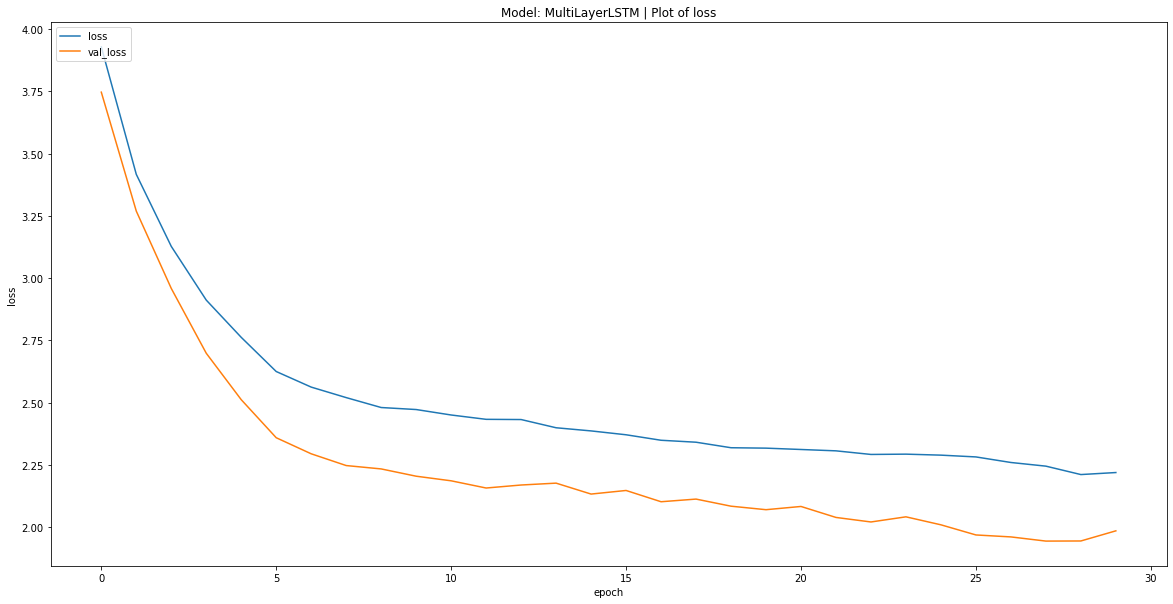

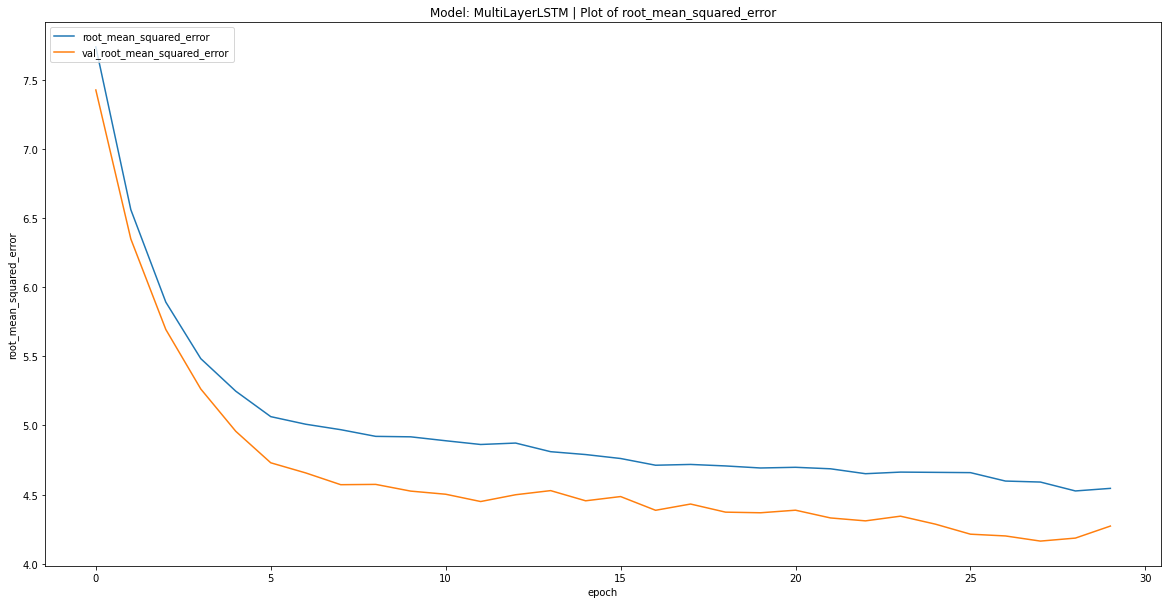

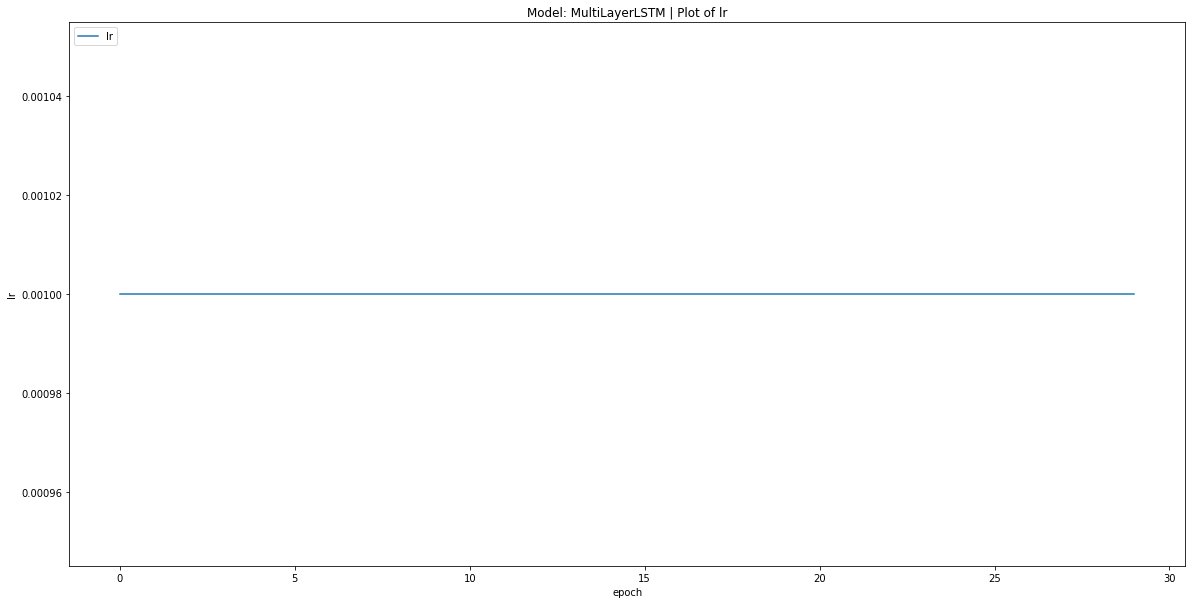

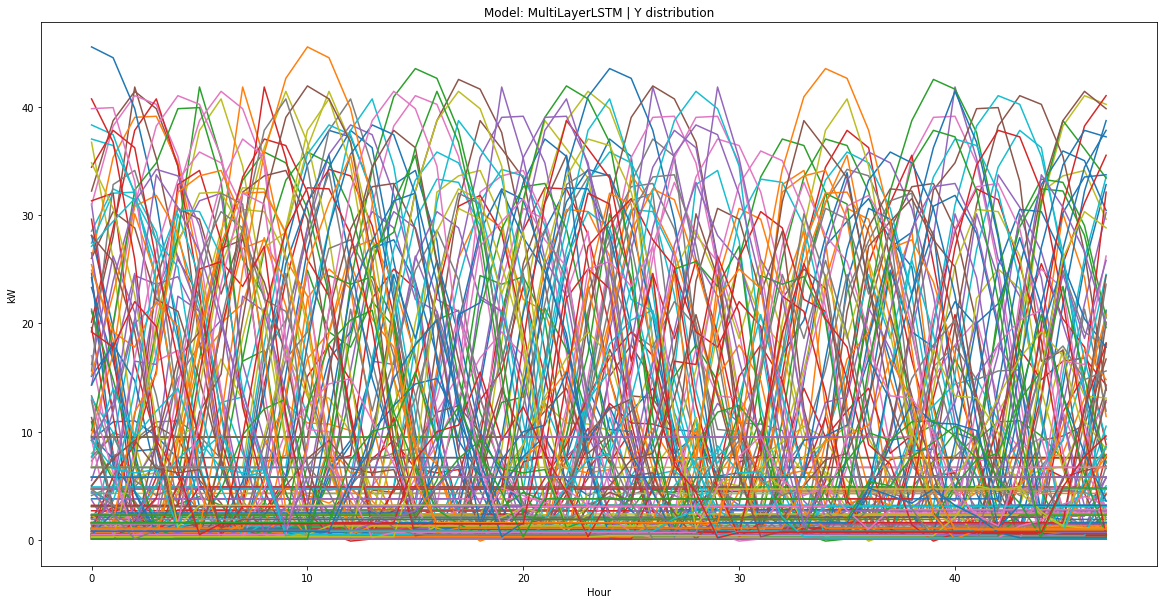

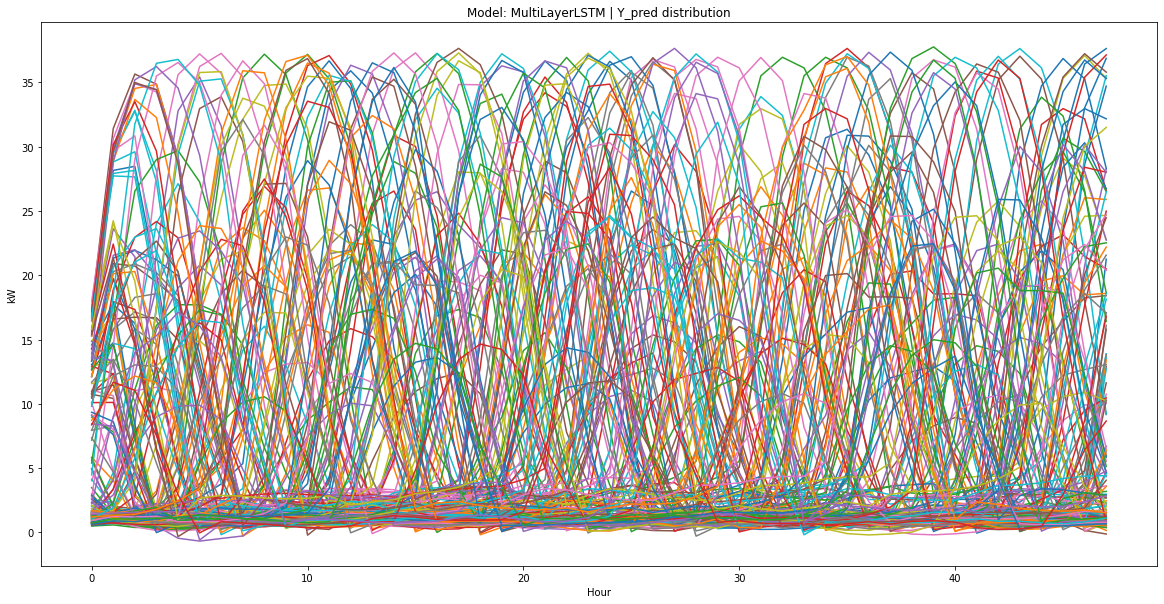

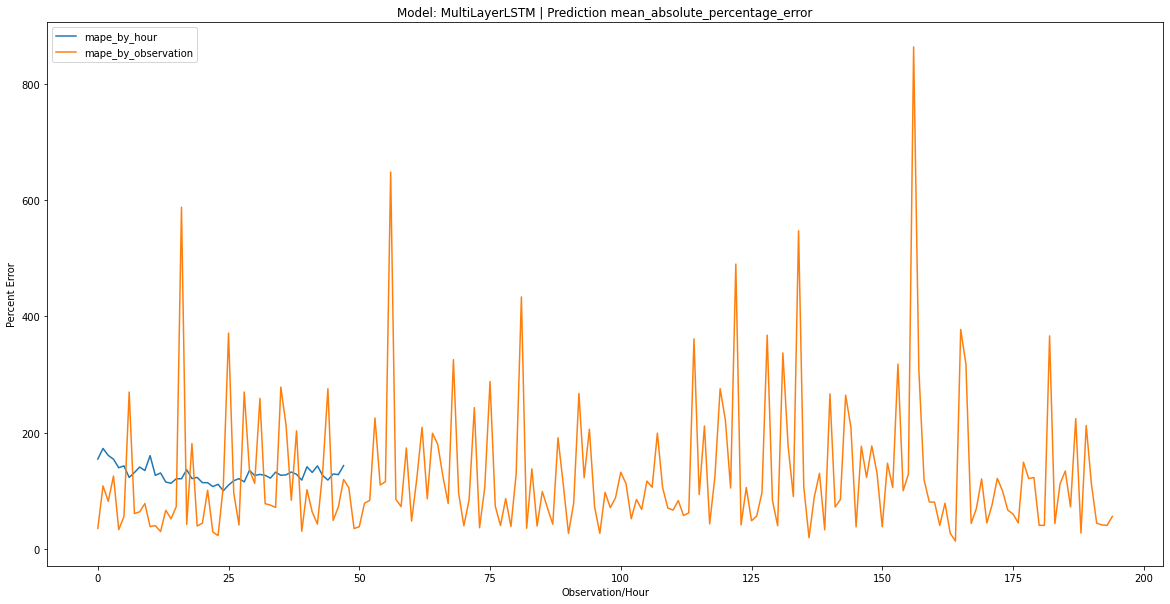

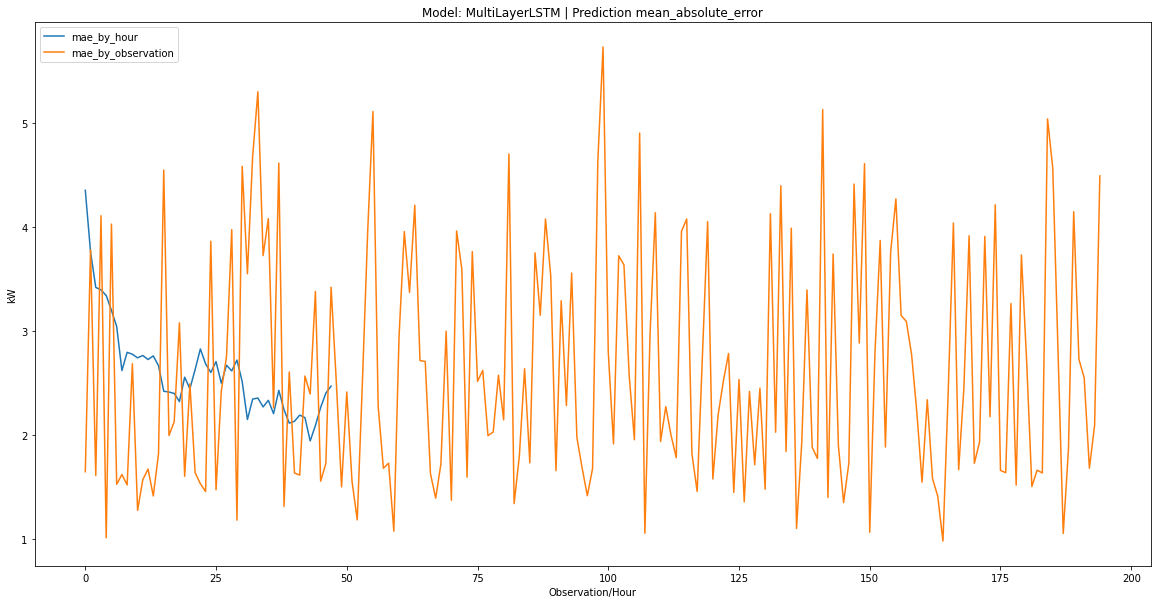

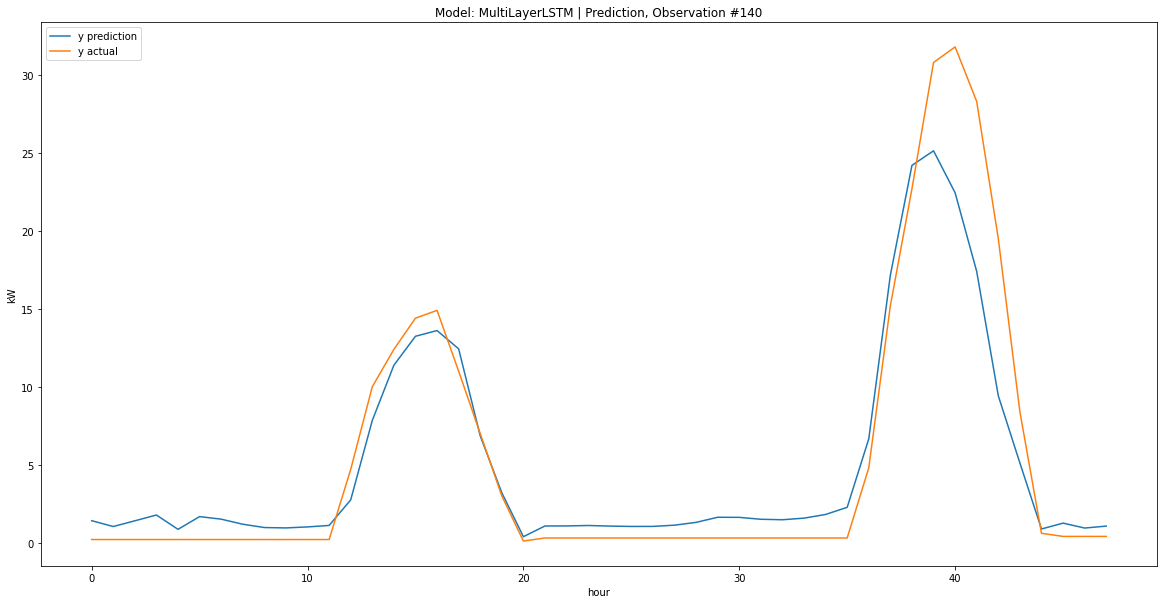

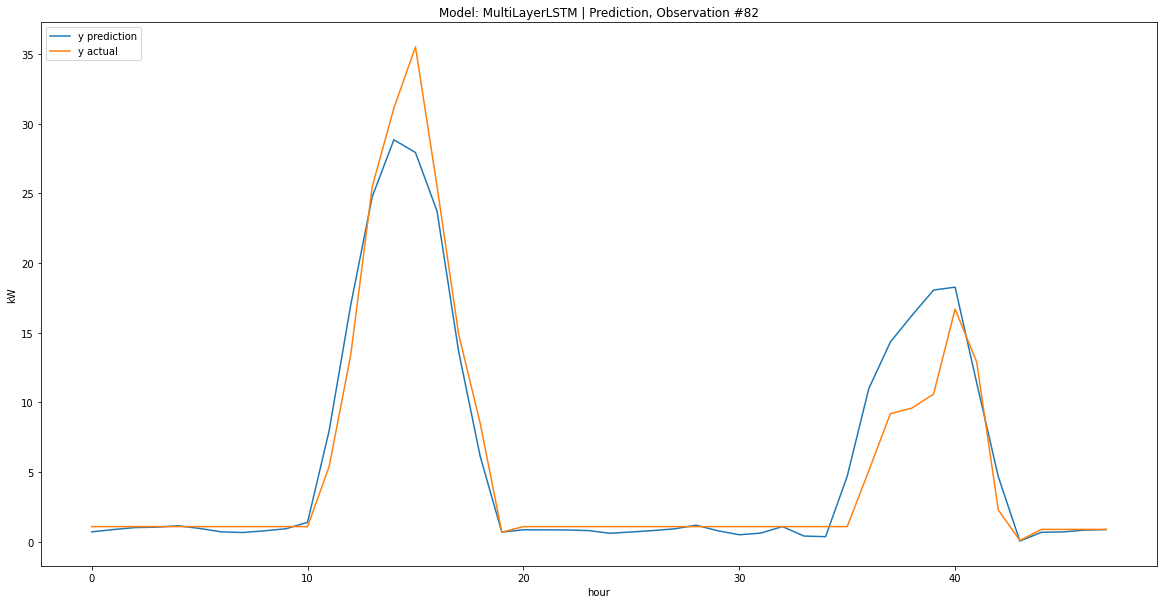

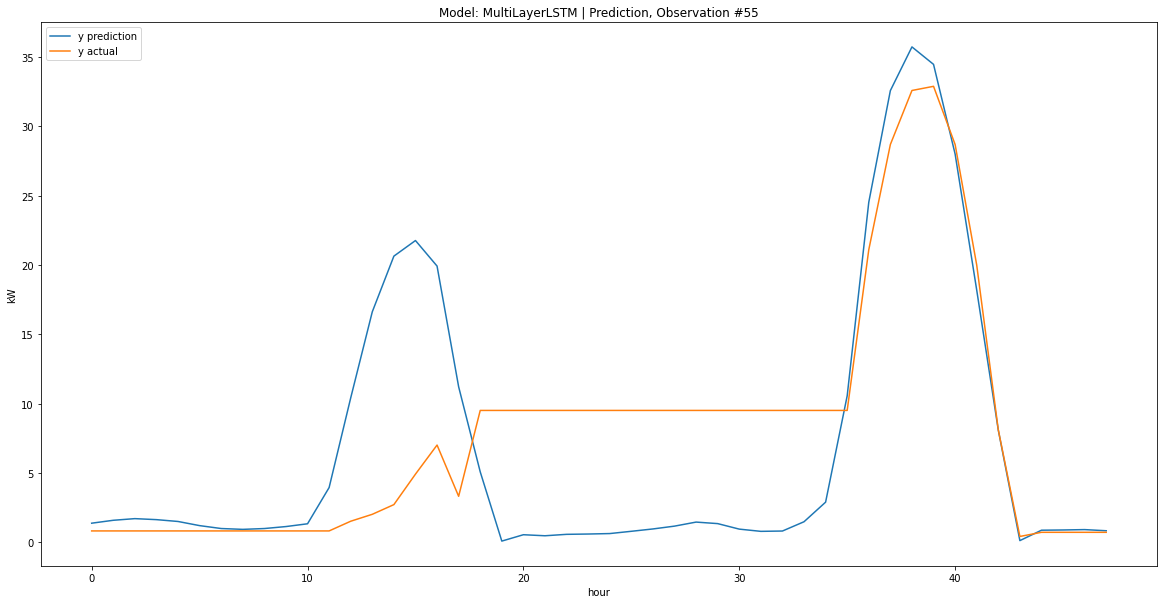

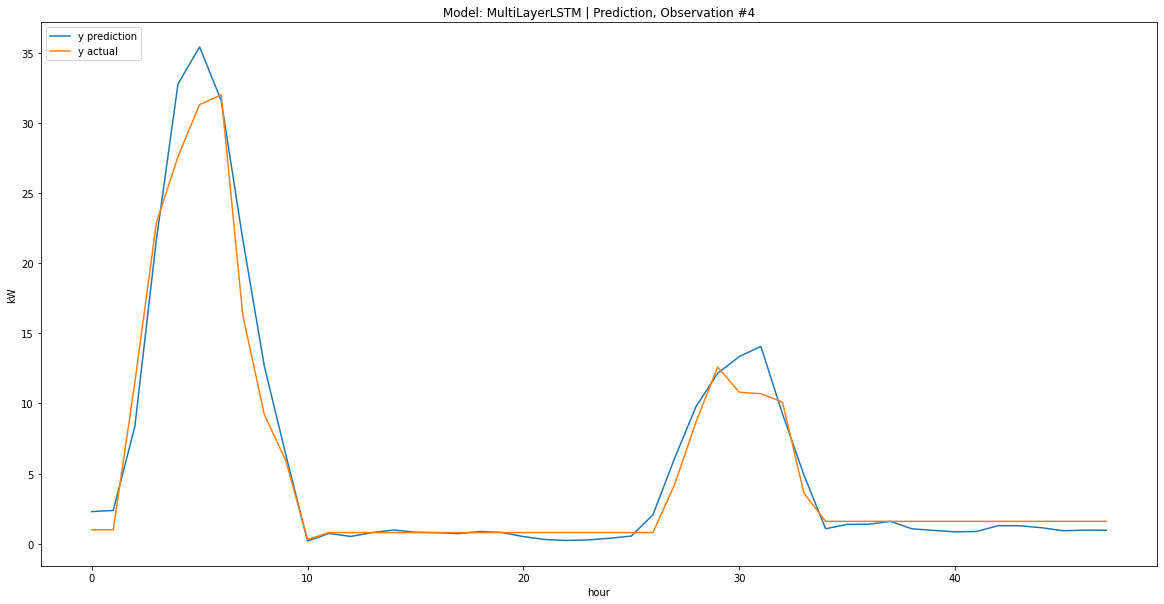

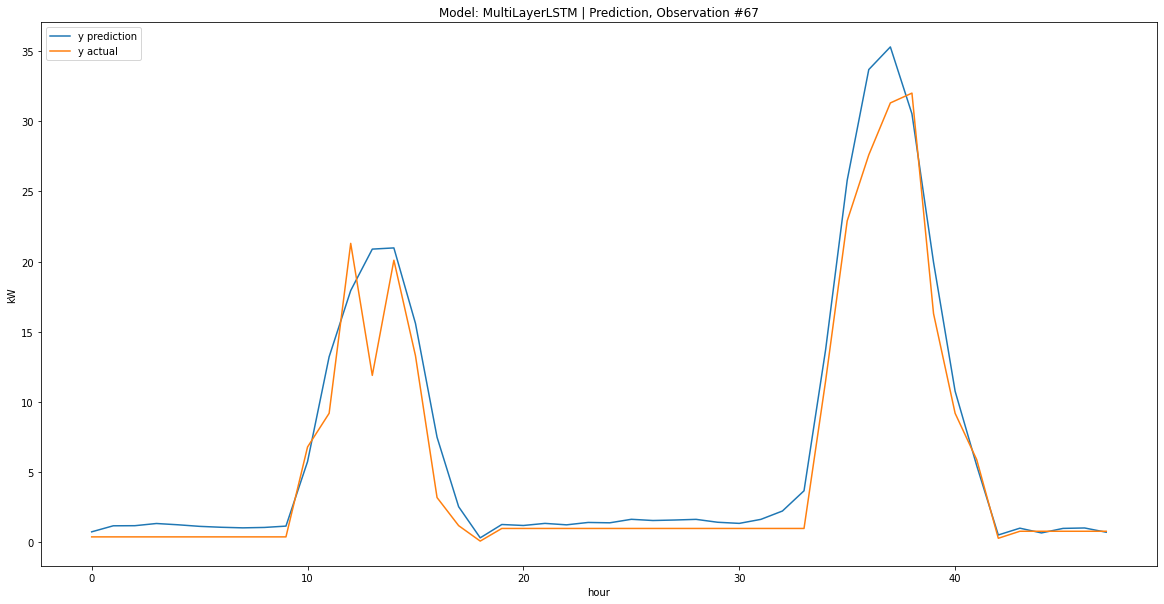

In [26]:
model_eval.EvaluateModel(lstm_model_2.model_name, lstm_model_2.model, lstm_model_2.history, x_test, y_solar_test)